### IMPORT LIBRARIES

In [1]:
# 2023034 - MAHMUT ZAHID MALKOC

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, IntegerType, FloatType
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, lit

from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import add,Conv2D,BatchNormalization,MaxPooling2D,Activation,Flatten,Dense,Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score

2023-10-05 15:50:01.055483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### IMPORT DATASET FROM HDFS

In [2]:
# 2023034 - MAHMUT ZAHID MALKOC

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ImageProcessing").getOrCreate()

hdfs_path = "/S2CA1/fer2013.csv"

df = spark.read.csv(hdfs_path, header=True, inferSchema=True)

### EXPLORATORY DATA ANALYSIS USING SPARK

In [3]:
# 2023034 - MAHMUT ZAHID MALKOC

# Show the dataframe
df.show()

+-------+--------------------+--------+
|emotion|              pixels|   Usage|
+-------+--------------------+--------+
|      0|70 80 82 72 58 58...|Training|
|      0|151 150 147 155 1...|Training|
|      2|231 212 156 164 1...|Training|
|      4|24 32 36 30 32 23...|Training|
|      6|4 0 0 0 0 0 0 0 0...|Training|
|      2|55 55 55 55 55 54...|Training|
|      4|20 17 19 21 25 38...|Training|
|      3|77 78 79 79 78 75...|Training|
|      3|85 84 90 121 101 ...|Training|
|      2|255 254 255 254 2...|Training|
|      0|30 24 21 23 25 25...|Training|
|      6|39 75 78 58 58 45...|Training|
|      6|219 213 206 202 2...|Training|
|      6|148 144 130 129 1...|Training|
|      3|4 2 13 41 56 62 6...|Training|
|      5|107 107 109 109 1...|Training|
|      3|14 14 18 28 27 22...|Training|
|      2|255 255 255 255 2...|Training|
|      6|134 124 167 180 1...|Training|
|      4|219 192 179 148 2...|Training|
+-------+--------------------+--------+
only showing top 20 rows



In [4]:
# 2023034 - MAHMUT ZAHID MALKOC

# Select the "emotion" column and find the unique values
unique_emotions = df.select("emotion").distinct().collect()

# Print the unique emotion values to the screen
for row in unique_emotions:
    print(row[0])

1
6
3
5
4
2
0


In [5]:
# 2023034 - MAHMUT ZAHID MALKOC

# Group the "Usage" column and count
usage_counts = df.groupBy("Usage").count()

# Print "usage_counts"
usage_counts.show()

+-----------+-----+
|      Usage|count|
+-----------+-----+
|   Training|28709|
| PublicTest| 3589|
|PrivateTest| 3589|
+-----------+-----+



In [6]:
# 2023034 - MAHMUT ZAHID MALKOC

# Describe the emotion map
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Calculate the count of each emotion category
emotion_counts = df.groupBy("emotion").count()

# Print "emotion_counts"
emotion_counts.show()

+-------+-----+
|emotion|count|
+-------+-----+
|      1|  547|
|      6| 6198|
|      3| 8989|
|      5| 4002|
|      4| 6077|
|      2| 5121|
|      0| 4953|
+-------+-----+



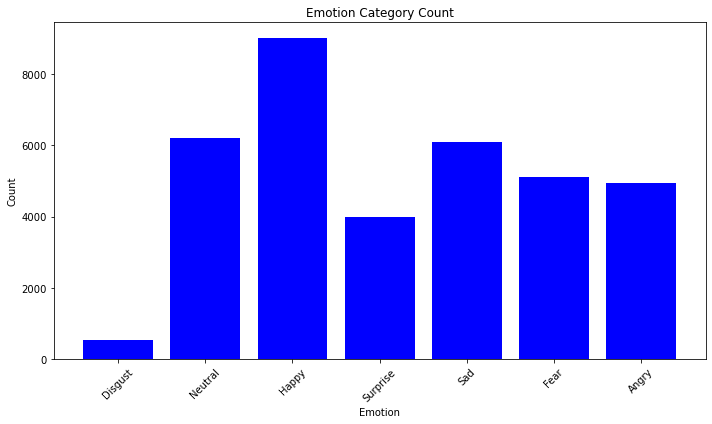

In [7]:
# 2023034 - MAHMUT ZAHID MALKOC

# Describe the labels
emotion_labels = ['Disgust', 'Neutral', 'Happy', 'Surprise', 'Sad', 'Fear', 'Angry']
emotion_counts = [547, 6198, 8989, 4002, 6077, 5121, 4953]

# Plot Bar Graph
plt.figure(figsize=(10, 6))
plt.bar(emotion_labels, emotion_counts, color='blue')

plt.xlabel('Emotion')
plt.ylabel('Count')

plt.title('Emotion Category Count')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

In [8]:
# 2023034 - MAHMUT ZAHID MALKOC

# Show "pixels" column first 5 rows
df.select("pixels").show(5)

+--------------------+
|              pixels|
+--------------------+
|70 80 82 72 58 58...|
|151 150 147 155 1...|
|231 212 156 164 1...|
|24 32 36 30 32 23...|
|4 0 0 0 0 0 0 0 0...|
+--------------------+
only showing top 5 rows



#### Convert Strings to Lists of Integers

In [9]:
# 2023034 - MAHMUT ZAHID MALKOC

from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, IntegerType

# Defining a function that converts string data into a list of integers
def string_to_int_list(s):
    return [int(x) for x in s.split()]

# UDF (User Defined Function) function definition
string_to_int_udf = udf(string_to_int_list, ArrayType(IntegerType()))

# Converting the "pixels" column and adding a new column
df = df.withColumn("pixels_as_int", string_to_int_udf(col("pixels")))

# Show the dataframe first 3 rows
df.show(3)

+-------+--------------------+--------+--------------------+
|emotion|              pixels|   Usage|       pixels_as_int|
+-------+--------------------+--------+--------------------+
|      0|70 80 82 72 58 58...|Training|[70, 80, 82, 72, ...|
|      0|151 150 147 155 1...|Training|[151, 150, 147, 1...|
|      2|231 212 156 164 1...|Training|[231, 212, 156, 1...|
+-------+--------------------+--------+--------------------+
only showing top 3 rows



#### Reshape to 48x48 and Normalise Grayscale Image with 255.0

In [10]:
# 2023034 - MAHMUT ZAHID MALKOC

from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Normalization process
max_value = 255.0
normalize_udf = udf(lambda x: [v / max_value for v in x], ArrayType(FloatType()))
df = df.withColumn("normalized_pixels", normalize_udf(df["pixels_as_int"]))

# Reshape Dataframe
width = 48
height = 48

# Reshape process
reshape_udf = udf(lambda x: [x[i:i+width] for i in range(0, len(x), width)], ArrayType(ArrayType(FloatType())))
df = df.withColumn("reshaped_pixels", reshape_udf(df["normalized_pixels"]))

# Show the dataframe first 3 rows
df.show(3)

+-------+--------------------+--------+--------------------+--------------------+--------------------+
|emotion|              pixels|   Usage|       pixels_as_int|   normalized_pixels|     reshaped_pixels|
+-------+--------------------+--------+--------------------+--------------------+--------------------+
|      0|70 80 82 72 58 58...|Training|[70, 80, 82, 72, ...|[0.27450982, 0.31...|[[0.27450982, 0.3...|
|      0|151 150 147 155 1...|Training|[151, 150, 147, 1...|[0.5921569, 0.588...|[[0.5921569, 0.58...|
|      2|231 212 156 164 1...|Training|[231, 212, 156, 1...|[0.90588236, 0.83...|[[0.90588236, 0.8...|
+-------+--------------------+--------+--------------------+--------------------+--------------------+
only showing top 3 rows



#### Perform One-Hot Encoding Label - e.g. class 3 to [0,0,0,1,0,0,0]

In [11]:
# 2023034 - MAHMUT ZAHID MALKOC

from pyspark.sql.functions import when, lit

# Define emotion mapping
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Convert emotion tags to one-hot encoding
for label, emotion in emotion_map.items():
    df = df.withColumn(emotion, when(df["emotion"] == lit(label), 1).otherwise(0))


# Select the "emotion" and one-hot encoding columns before removing the 'emotion' column
selected_columns = ["emotion"] + list(emotion_map.values())

# Show only "selected_columns"
df.select(selected_columns).show()

+-------+-----+-------+----+-----+---+--------+-------+
|emotion|Angry|Disgust|Fear|Happy|Sad|Surprise|Neutral|
+-------+-----+-------+----+-----+---+--------+-------+
|      0|    1|      0|   0|    0|  0|       0|      0|
|      0|    1|      0|   0|    0|  0|       0|      0|
|      2|    0|      0|   1|    0|  0|       0|      0|
|      4|    0|      0|   0|    0|  1|       0|      0|
|      6|    0|      0|   0|    0|  0|       0|      1|
|      2|    0|      0|   1|    0|  0|       0|      0|
|      4|    0|      0|   0|    0|  1|       0|      0|
|      3|    0|      0|   0|    1|  0|       0|      0|
|      3|    0|      0|   0|    1|  0|       0|      0|
|      2|    0|      0|   1|    0|  0|       0|      0|
|      0|    1|      0|   0|    0|  0|       0|      0|
|      6|    0|      0|   0|    0|  0|       0|      1|
|      6|    0|      0|   0|    0|  0|       0|      1|
|      6|    0|      0|   0|    0|  0|       0|      1|
|      3|    0|      0|   0|    1|  0|       0| 

In [12]:
# 2023034 - MAHMUT ZAHID MALKOC

# Show the whole dataset
df.show()

+-------+--------------------+--------+--------------------+--------------------+--------------------+-----+-------+----+-----+---+--------+-------+
|emotion|              pixels|   Usage|       pixels_as_int|   normalized_pixels|     reshaped_pixels|Angry|Disgust|Fear|Happy|Sad|Surprise|Neutral|
+-------+--------------------+--------+--------------------+--------------------+--------------------+-----+-------+----+-----+---+--------+-------+
|      0|70 80 82 72 58 58...|Training|[70, 80, 82, 72, ...|[0.27450982, 0.31...|[[0.27450982, 0.3...|    1|      0|   0|    0|  0|       0|      0|
|      0|151 150 147 155 1...|Training|[151, 150, 147, 1...|[0.5921569, 0.588...|[[0.5921569, 0.58...|    1|      0|   0|    0|  0|       0|      0|
|      2|231 212 156 164 1...|Training|[231, 212, 156, 1...|[0.90588236, 0.83...|[[0.90588236, 0.8...|    0|      0|   1|    0|  0|       0|      0|
|      4|24 32 36 30 32 23...|Training|[24, 32, 36, 30, ...|[0.09411765, 0.12...|[[0.09411765, 0.1...|    

#### Prepare the Dataset for Model Training

In [13]:
# 2023034 - MAHMUT ZAHID MALKOC

# # Select only the required "emotion" and "normalized_pixels" columns
df = df.select("emotion", "normalized_pixels", "Usage")

# Show the special and required dataset
df.show()

+-------+--------------------+--------+
|emotion|   normalized_pixels|   Usage|
+-------+--------------------+--------+
|      0|[0.27450982, 0.31...|Training|
|      0|[0.5921569, 0.588...|Training|
|      2|[0.90588236, 0.83...|Training|
|      4|[0.09411765, 0.12...|Training|
|      6|[0.015686275, 0.0...|Training|
|      2|[0.21568628, 0.21...|Training|
|      4|[0.078431375, 0.0...|Training|
|      3|[0.3019608, 0.305...|Training|
|      3|[0.33333334, 0.32...|Training|
|      2|[1.0, 0.99607843,...|Training|
|      0|[0.11764706, 0.09...|Training|
|      6|[0.15294118, 0.29...|Training|
|      6|[0.85882354, 0.83...|Training|
|      6|[0.5803922, 0.564...|Training|
|      3|[0.015686275, 0.0...|Training|
|      5|[0.41960785, 0.41...|Training|
|      3|[0.05490196, 0.05...|Training|
|      2|[1.0, 1.0, 1.0, 1...|Training|
|      6|[0.5254902, 0.486...|Training|
|      4|[0.85882354, 0.75...|Training|
+-------+--------------------+--------+
only showing top 20 rows



### SPLIT THE DATASET INTO TRAIN - TEST - VALIDATION DATA

In [14]:
# 2023034 - MAHMUT ZAHID MALKOC

# Split the data into 80% train and 20% other
train_data = df.sample(False, 0.8, seed=123)
remaining_data = df.subtract(train_data)

# Split the other into 10% validation and 10% test
validation_data = remaining_data.sample(False, 0.5, seed=123)
test_data = remaining_data.subtract(validation_data)

# Show the shape of data 
print(f"Shape of Train Data     : {train_data.count()     , len(train_data.columns)}")
print(f"Shape of Test Data      : {test_data.count()      , len(test_data.columns)}")
print(f"Shape of Validation Data: {validation_data.count(), len(validation_data.columns)}")

Shape of Train Data     : (28754, 3)


Shape of Test Data      : (3296, 3)


Shape of Validation Data: (3441, 3)


#### Prepare the Dataset for CNN

In [15]:
# 2023034 - MAHMUT ZAHID MALKOC

# Define train_X and train_y - It is better to use array than list for ML/DL
# train_X = train_data.select("normalized_pixels").collect()
# train_Y = train_data.select("emotion").collect()

# Define train_X and train_y
train_X = np.array([row["normalized_pixels"] for row in train_data.collect()])
train_y = np.array([row["emotion"]           for row in train_data.collect()])

# Print train_X and train_y
print("train_X:", len(train_X))
print("train_y:", len(train_y))

train_X: 28754
train_y: 28754


In [16]:
# 2023034 - MAHMUT ZAHID MALKOC

# Define test_X and test_y
test_X = np.array([row["normalized_pixels"] for row in test_data.collect()])
test_y = np.array([row["emotion"]           for row in test_data.collect()])

# Print test_X and test_y
print("test_X :", len(test_X))
print("test_y :", len(test_y))

test_X : 3296
test_y : 3296


In [17]:
# 2023034 - MAHMUT ZAHID MALKOC

# Define val_X and val_y
val_X = np.array([row["normalized_pixels"] for row in validation_data.collect()])
val_y = np.array([row["emotion"]           for row in validation_data.collect()])

# Print val_X and val_y
print("val_X  :", len(val_X))
print("val_y  :", len(val_y))

val_X  : 3441
val_y  : 3441


In [18]:
# 2023034 - MAHMUT ZAHID MALKOC

# RESHAPE TRAIN, TEST AND VAL (X,y)
train_X = train_X.reshape(train_X.shape[0], 48, 48, 1)
test_X  = test_X.reshape(test_X.shape[0], 48, 48, 1)
val_X   = val_X.reshape(val_X.shape[0], 48, 48, 1)

# PRINT TRAIN, TEST AND VAL (X,y)
print("train_X:", len(train_X))
print("test_X :", len(test_X))
print("val_X  :", len(val_X))

train_X: 28754
test_X : 3296
val_X  : 3441


### CNN ARCHITECTURE  

In [25]:
# 2023034 - MAHMUT ZAHID MALKOC

### INITILIZE PARAMETERS ###
# Number of Classes
num_classes = 7 
# Width and Height
width, height = 48, 48
# Number of Epoch
num_epochs = 1
# Splitting Data Into Small Batch
batch_size = 256
# Number of Neurons in Hidden Layers
num_features = 64

In [26]:
# 2023034 - MAHMUT ZAHID MALKOC

from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import add,Conv2D,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Activation,Flatten,Dense,Input
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential()

# Module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width,height,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
model.add(Flatten())

# Dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

In [27]:
# 2023034 - MAHMUT ZAHID MALKOC

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 40)        400       
                                                                 
 batch_normalization_9 (Bat  (None, 46, 46, 40)        160       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 46, 46, 40)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 40)        14440     
                                                                 
 batch_normalization_10 (Ba  (None, 46, 46, 40)        160       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 46, 46, 40)       

In [28]:
# 2023034 - MAHMUT ZAHID MALKOC

from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 40)        400       
                                                                 
 batch_normalization_9 (Bat  (None, 46, 46, 40)        160       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 46, 46, 40)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 40)        14440     
                                                                 
 batch_normalization_10 (Ba  (None, 46, 46, 40)        160       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 46, 46, 40)       

In [29]:
# 2023034 - MAHMUT ZAHID MALKOC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Data Generator (Data Augmentation)
data_generator = ImageDataGenerator(featurewise_center = False,
                                    featurewise_std_normalization = False,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = .1,
                                    horizontal_flip = True)
# Early Stopping (Regularization)
es = EarlyStopping(monitor = 'val_loss', 
                   patience = 10, 
                   mode = 'min', 
                   restore_best_weights = True)

In [30]:
# 2023034 - MAHMUT ZAHID MALKOC

# Model Fit
history = model.fit(data_generator.flow(train_X, train_y, batch_size),
                    steps_per_epoch = len(train_X) / batch_size,
                    epochs = 1,
                    verbose = 2, 
                    callbacks = [es],
                    validation_data = (val_X, val_y))

2023-10-05 16:29:08.462148: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 86671360 exceeds 10% of free system memory.
2023-10-05 16:29:08.484137: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 86671360 exceeds 10% of free system memory.
2023-10-05 16:29:08.591795: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 86671360 exceeds 10% of free system memory.
2023-10-05 16:29:08.716256: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 86671360 exceeds 10% of free system memory.
2023-10-05 16:29:09.187375: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 86671360 exceeds 10% of free system memory.


112/112 - 173s - loss: 1.8623 - accuracy: 0.2393 - val_loss: 1.8244 - val_accuracy: 0.2674 - 173s/epoch - 2s/step


### VISUALISE TRAINING PERFORMANCE 

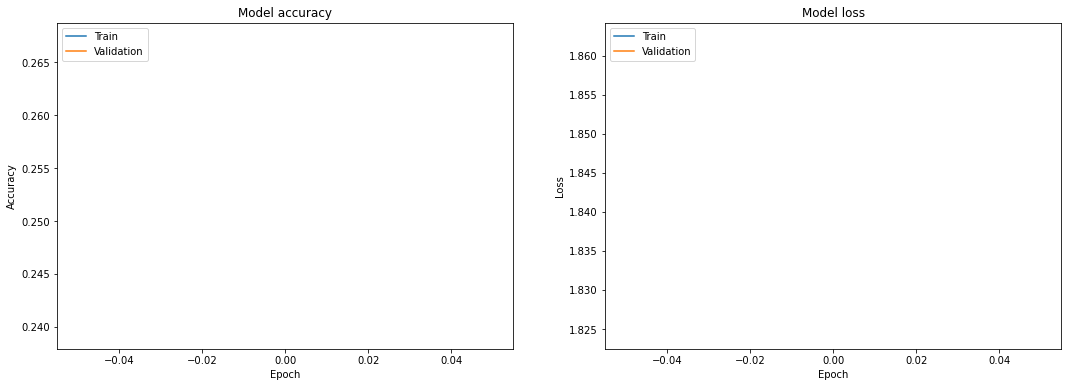

In [31]:
# 2023034 - MAHMUT ZAHID MALKOC

fig, axes = plt.subplots(1,2, figsize=(18, 6))

# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

### EVALUATE TEST PERFORMANCE

In [32]:
# 2023034 - MAHMUT ZAHID MALKOC

from sklearn.metrics import accuracy_score

# Make predictions on the "test_X"
predictions = model.predict(test_X)

# The index of the class with the highest value is found,
# For each data point of the predictions.
predicted_classes = np.argmax(predictions, axis=1)

# Each test example is compared with the actual class label and the predicted class index.
# The number of correct predictions is summed and 
# The accuracy rate is calculated by dividing it by the total number of data points.
test_accuracy = accuracy_score(test_y, predicted_classes)

# Show the test accuracy rate
print("Test Accuracy:", test_accuracy)

103/103 [==============================] - 4s 37ms/step
Test Accuracy: 0.2554611650485437
